In [1]:
# STEP 1: Import Libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import joblib
import random
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns


In [2]:
# STEP 2: Set Directory Paths
base_dir = os.path.join("C:", os.sep, "Users", "bhava", "OneDrive", "Desktop", "Image classification using CNN", "archive", "chest_xray")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
categories = ["NORMAL", "PNEUMONIA"]

In [3]:
# STEP 3: Count number of images per category
def count_images(folder_path):
    counts = {}
    for category in categories:
        path = os.path.join(folder_path, category)
        counts[category] = len(os.listdir(path))
    return counts

print("Train set:", count_images(train_dir))
print("Validation set:", count_images(val_dir))
print("Test set:", count_images(test_dir))


Train set: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation set: {'NORMAL': 8, 'PNEUMONIA': 8}
Test set: {'NORMAL': 234, 'PNEUMONIA': 390}


In [4]:
IMG_WIDTH = 280
IMG_HEIGHT = 224
DATASET_PATH = os.path.join("C:", os.sep, "Users", "bhava", "OneDrive", "Desktop", "Image classification using CNN", "archive", "chest_xray", "train")
def load_images(data_path):
    X = []
    y = []
    for label in ['NORMAL', 'PNEUMONIA']:
        folder_path = os.path.join(data_path, label)
        for img_file in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0  # Normalize
                X.append(img.flatten())  # Flatten for traditional ML
                y.append(label)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")
    return np.array(X), np.array(y)

X, y = load_images(DATASET_PATH)

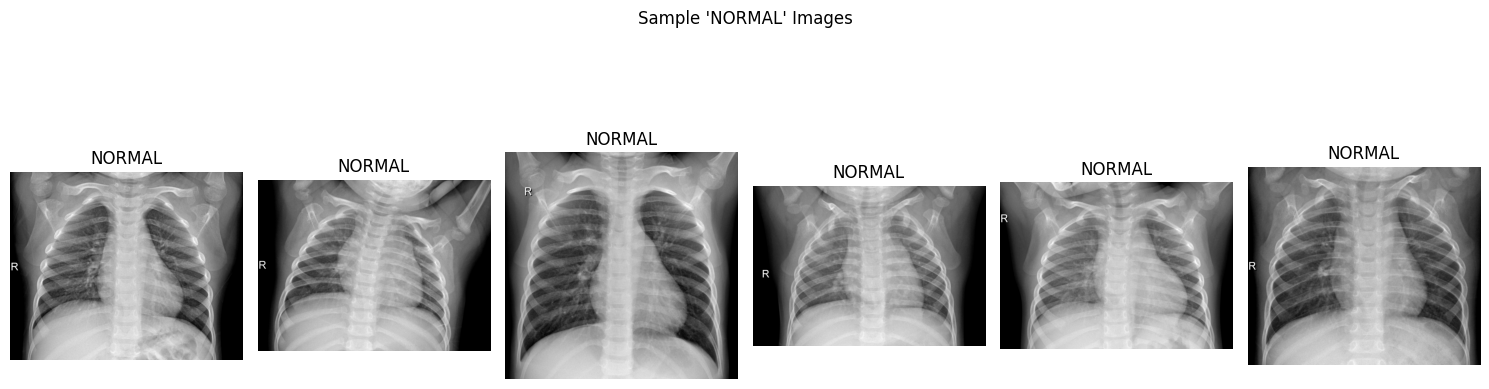

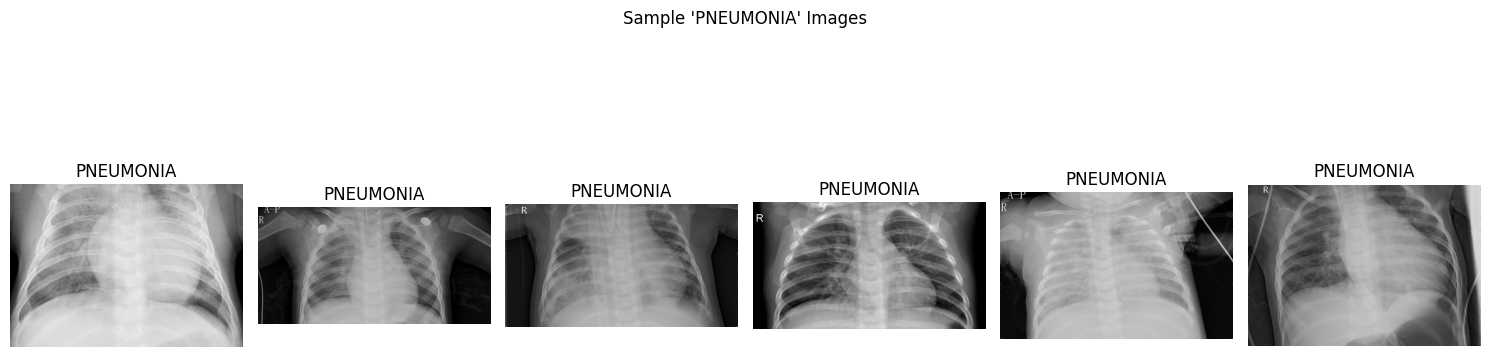

In [5]:
# STEP 4: Plot Sample Images
def show_sample_images(folder, label, n=6):
    path = os.path.join(folder, label)
    sample_files = random.sample(os.listdir(path), n)

    plt.figure(figsize=(15, 5))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(path, file)
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img.convert('L'), cmap="gray")
        plt.title(label)
        plt.axis('off')
    plt.suptitle(f"Sample '{label}' Images")
    plt.tight_layout()
    plt.show()

show_sample_images(train_dir, "NORMAL")
show_sample_images(train_dir, "PNEUMONIA")

Checking sizes in category: NORMAL
  Processed 50/300 images...
  Processed 100/300 images...
  Processed 150/300 images...
  Processed 200/300 images...
  Processed 250/300 images...
  Processed 300/300 images...
Checking sizes in category: PNEUMONIA
  Processed 50/300 images...
  Processed 100/300 images...
  Processed 150/300 images...
  Processed 200/300 images...
  Processed 250/300 images...
  Processed 300/300 images...


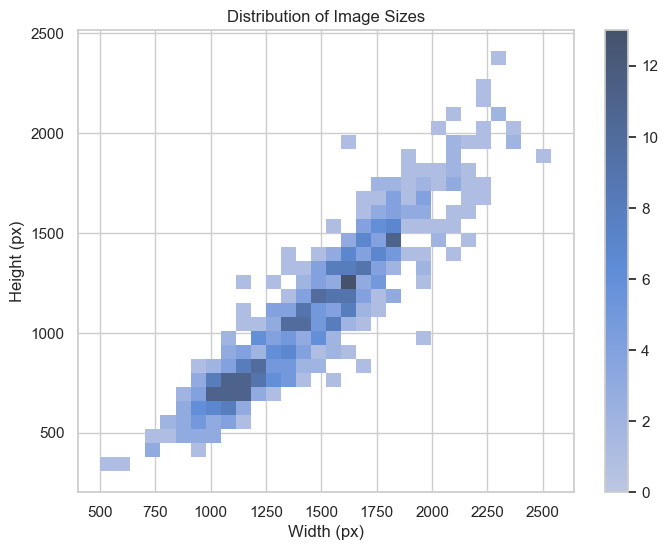

In [6]:
# STEP 5: Image Shape Consistency Check (without tqdm)
image_shapes = []

for category in categories:
    path = os.path.join(train_dir, category)
    print(f"Checking sizes in category: {category}")
    
    image_list = os.listdir(path)[:300]
    total = len(image_list)

    for i, img_name in enumerate(image_list):
        try:
            img = Image.open(os.path.join(path, img_name))
            image_shapes.append(img.size)
        except:
            continue

        # Log progress every 50 images
        if (i + 1) % 50 == 0 or (i + 1) == total:
            print(f"  Processed {i + 1}/{total} images...")

# Plotting the shape distribution
shape_array = np.array(image_shapes)
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(x=shape_array[:, 0], y=shape_array[:, 1], bins=30, cbar=True)
plt.title("Distribution of Image Sizes")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.show()


In [7]:
# STEP 6: Resize All Images to 150x150 and Save to Cleaned Folder
from tqdm import tqdm
IMG_SIZE = (150, 150)
save_dir = os.path.join("C:", os.sep, "Users", "bhava", "Downloads", "archive", "data", "cleaned")

for folder in ["train", "val", "test"]:
    for label in categories:
        src = os.path.join(base_dir, folder, label)
        dst = os.path.join(save_dir, folder, label)
        os.makedirs(dst, exist_ok=True)

        for img_name in tqdm(os.listdir(src), desc=f"Resizing {folder}/{label}"):
            img_path = os.path.join(src, img_name)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    resized = cv2.resize(img, IMG_SIZE)
                    cv2.imwrite(os.path.join(dst, img_name), resized)
            except:
                continue

Resizing test/PNEUMONIA: 100%|███████████████████████████████████████████████████████| 390/390 [00:04<00:00, 86.21it/s]


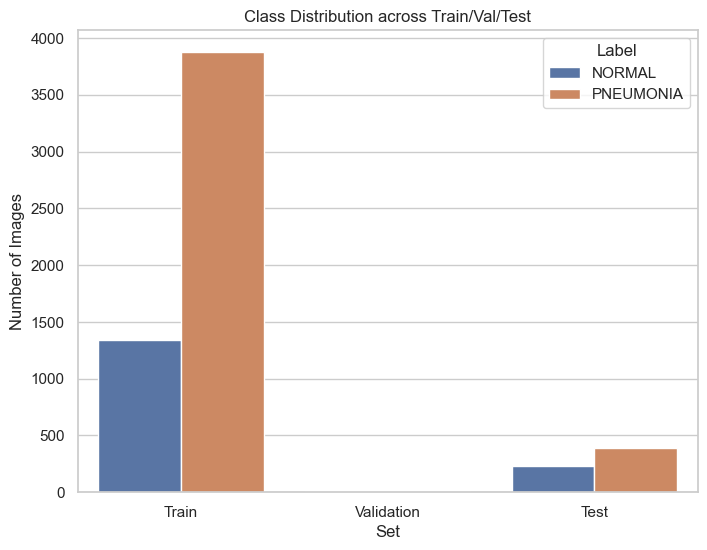

In [8]:
# Class Distribution (Bar Chart)
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

all_counts = {
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
}

df_counts = []

for split, data in all_counts.items():
    for label, count in data.items():
        df_counts.append({'Set': split, 'Label': label, 'Count': count})

import pandas as pd
df_counts = pd.DataFrame(df_counts)

plt.figure(figsize=(8,6))
sns.barplot(data=df_counts, x="Set", y="Count", hue="Label")
plt.title("Class Distribution across Train/Val/Test")
plt.ylabel("Number of Images")
plt.show()


C:\Users\bhava\AppData\Local\Temp\ipykernel_20592\967305373.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_brightness, x="Label", y="Brightness", palette="pastel")


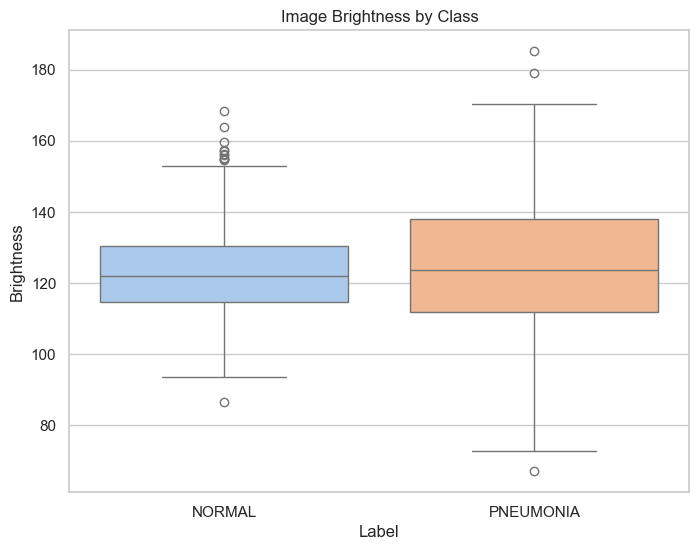

In [9]:
#Image Brightness Distribution
def calculate_brightness(image_path):
    img = Image.open(image_path).convert("L")
    return np.mean(img)

brightness_scores = []

for category in categories:
    path = os.path.join(train_dir, category)
    for img_name in random.sample(os.listdir(path), 300):
        try:
            score = calculate_brightness(os.path.join(path, img_name))
            brightness_scores.append({'Label': category, 'Brightness': score})
        except:
            continue

df_brightness = pd.DataFrame(brightness_scores)

plt.figure(figsize=(8,6))
sns.boxplot(data=df_brightness, x="Label", y="Brightness", palette="pastel")
plt.title("Image Brightness by Class")
plt.show()


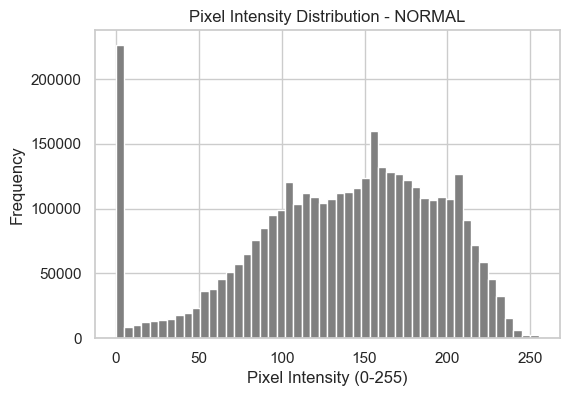

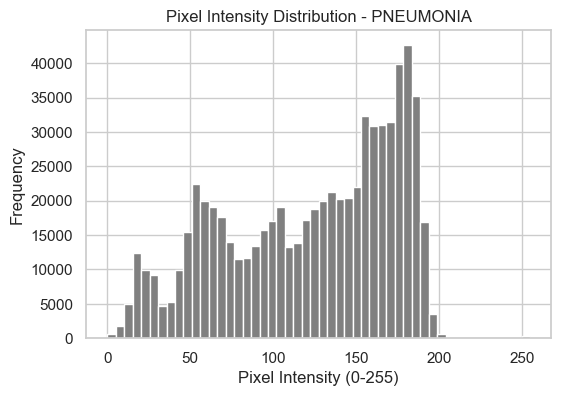

In [10]:
#Pixel Intensity Histograms
def plot_intensity_histogram(folder, label):
    path = os.path.join(folder, label)
    img_sample = Image.open(os.path.join(path, random.choice(os.listdir(path)))).convert('L')
    plt.figure(figsize=(6,4))
    plt.hist(np.array(img_sample).ravel(), bins=50, color='gray')
    plt.title(f"Pixel Intensity Distribution - {label}")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")
    plt.show()

for lbl in categories:
    plot_intensity_histogram(train_dir, lbl)


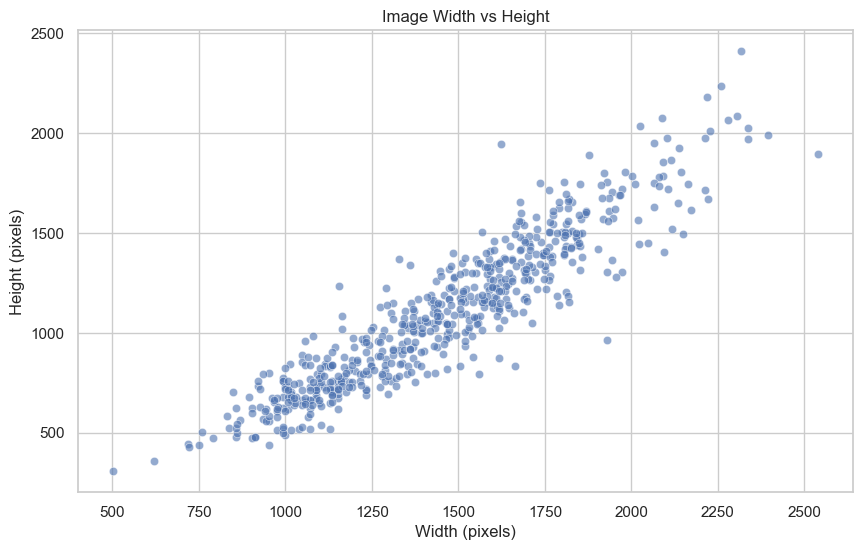

In [11]:
#Image Size Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=shape_array[:, 0], y=shape_array[:, 1], alpha=0.6)
plt.title("Image Width vs Height")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(True)
plt.show()


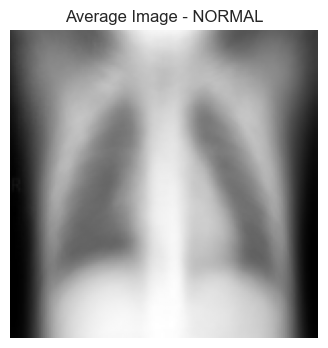

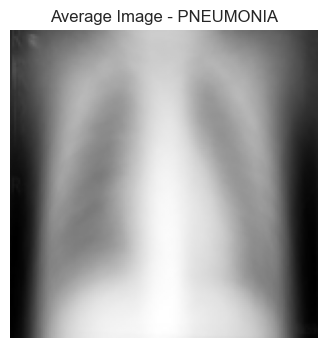

In [12]:
#Class-wise Average Image
def average_image(folder_path, label):
    imgs = []
    files = os.listdir(os.path.join(folder_path, label))[:300]
    for file in files:
        try:
            img = Image.open(os.path.join(folder_path, label, file)).convert('L').resize((150, 150))
            imgs.append(np.array(img))
        except:
            continue
    avg_img = np.mean(imgs, axis=0)
    return avg_img

for lbl in categories:
    avg = average_image(train_dir, lbl)
    plt.figure(figsize=(4,4))
    plt.imshow(avg, cmap='gray')
    plt.title(f"Average Image - {lbl}")
    plt.axis('off')
    plt.show()


In [13]:
X, y = shuffle(X, y, random_state=42)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [14]:
# Feature Extraction Using MobileNetV2 (No Top Layer)
#Load & Preprocess Data
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

IMG_SIZE = 224  # MobileNetV2 expects 224x224

def load_images_and_labels(folder):
    data = []
    labels = []
    for label in categories:  # ['NORMAL', 'PNEUMONIA']
        path = os.path.join(folder, label)
        for img_name in os.listdir(path)[:500]:  # limit if needed
            try:
                img_path = os.path.join(path, img_name)
                img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img = img_to_array(img)
                img = preprocess_input(img)
                data.append(img)
                labels.append(label)
            except:
                continue
    return np.array(data), np.array(labels)

X, y = load_images_and_labels(train_dir)
print(f"✅ Loaded {X.shape[0]} images")

# Load MobileNetV2 without top layers for feature extraction
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = feature_extractor.predict(X, batch_size=32, verbose=1)

# Flatten features for use with traditional ML models
features_flat = features.reshape(features.shape[0], -1)
print(f"✅ Extracted features shape: {features_flat.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Make sure features and labels match in length
assert features_flat.shape[0] == len(y_encoded), "Features and labels must have same length"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"✅ Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")

✅ Loaded 1000 images
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 440ms/step
✅ Extracted features shape: (1000, 62720)
✅ Data split: 800 training samples, 200 test samples


In [15]:
"""from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

features = feature_extractor.predict(X, batch_size=32, verbose=1)
features_flat = features.reshape(features.shape[0], -1)

# Assuming features_flat is already created by MobileNetV2 + reshape
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

assert features_flat.shape[0] == len(y_encoded), "Features and labels must have same length"

X_train, X_test, y_train, y_test = train_test_split(
    features_flat, y_encoded, test_size=0.2, random_state=42
)

# Now train sklearn models on X_train (2D array), not raw images
"""


'from sklearn.preprocessing import LabelEncoder\nfrom sklearn.model_selection import train_test_split\n\nfeatures = feature_extractor.predict(X, batch_size=32, verbose=1)\nfeatures_flat = features.reshape(features.shape[0], -1)\n\n# Assuming features_flat is already created by MobileNetV2 + reshape\nlabel_encoder = LabelEncoder()\ny_encoded = label_encoder.fit_transform(y)\n\nassert features_flat.shape[0] == len(y_encoded), "Features and labels must have same length"\n\nX_train, X_test, y_train, y_test = train_test_split(\n    features_flat, y_encoded, test_size=0.2, random_state=42\n)\n\n# Now train sklearn models on X_train (2D array), not raw images\n'

In [16]:
# Encode Labels
#le = LabelEncoder()
#y_encoded = le.fit_transform(y)  # 0: NORMAL, 1: PNEUMONIA

# Train-test split
#X_train, X_val, y_train, y_val = train_test_split(features_flat, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Assuming features_flat (2D array) and y (labels) are already prepared

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split using extracted features (features_flat), NOT raw images
X_train, X_test, y_train, y_test = train_test_split(
    features_flat, y_encoded, test_size=0.2, random_state=42
)

# Define models
models = {
    'SVM': SVC(probability=True, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5),  # no class_weight
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced')
}

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, preds, target_names=label_encoder.classes_))
    joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.pkl')

# Save label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')


Training SVM...
Classification Report for SVM:

              precision    recall  f1-score   support

      NORMAL       0.96      1.00      0.98        96
   PNEUMONIA       1.00      0.96      0.98       104

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


Training Random Forest...
Classification Report for Random Forest:

              precision    recall  f1-score   support

      NORMAL       0.93      1.00      0.96        96
   PNEUMONIA       1.00      0.93      0.97       104

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200


Training Logistic Regression...
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

      NORMAL       0.99      1.00      0.99        96
   PNEUMONIA       1.00      0.99     

['label_encoder.pkl']

In [18]:
import joblib

# Assuming you have trained models in a dictionary like this:
models = {
    'logistic_regression': logreg,
    'svm': svm,
    'random_forest': rf,
    'knn': knn,
    'decision_tree': dt
}

# Save all models
for model_name, model_obj in models.items():
    joblib.dump(model_obj, f"{model_name}_model.pkl")

# Save the label encoder separately
joblib.dump(label_encoder, "label_encoder.pkl")

print("All models and label encoder saved!")


NameError: name 'logreg' is not defined